# Aprendizaje ensemble evolutivo basado en voting con feature selection para clasificación

### Descripción

<font size="4"> Algoritmo evolutivo para aprendizaje ensemble basado en voting con feature selection en tareas de clasificación (minimización).

### Componentes
    
- <font size="3"> Método voting de aprendizaje ensemble
    
- <font size="3"> Datos:
    
    - <font size="3"> Regresión

    - <font size="3"> Entradas numéricas

- <font size="3"> Algoritmo evolutivo:
    
    - <font size="3"> Representación binaria 

    - <font size="3"> Selección por torneo binario

    - <font size="3"> Muestreo estocástico con reemplazamiento

    - <font size="3"> Sustitución $(\mu+\lambda)$

    - <font size="3"> Elitista

    - <font size="3"> Cruce uniforme

    - <font size="3"> Mutación uniforme

### Comentarios
    
- <font size="3"> Se requiere ordenar una población de $2 \cdot N$ individuos con los $\mu$ padres más los $\lambda$ hijos, $\mu=\lambda=N$.    
    
- <font size="3"> Se leen los datos en formato arff.
    
- <font size="3"> Se imputan los missing values con la media (atributos numéricos).
    
- <font size="3"> Los datos de entrada y la salida se convierten en arrays numpy para mayor eficiencia en los cálculos.

---    

### Requerimientos

In [62]:
import numpy as np
import heapq 
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

### Lectura de los datos
#### Input:
  - $file\_path$: Nombre completo con path de la base de datos .arff a cargar
  
#### Output:
  - $X$: Atributos de entrada numéricos
  - $y$: Salida numérica

In [63]:
def LoadData(file_path):

    data, meta = arff.loadarff(file_path)

    # Convertir a DataFrame
    df = pd.DataFrame(data)

    # Imputación de los atributos numéricos
    df.iloc[:, :-1] = SimpleImputer(strategy='mean').fit_transform(df.iloc[:, :-1])

    # Separar en entradas (X) y salida (y)
    X = df.iloc[:, :-1]      # Entradas: X
    y = df.iloc[:, -1]       # Salidas: y (la última columna)

    # Convertir las entradas y salidas en arrays numpy
    X = np.array(X)
    y = np.array(y)    
    
    return X,y

### Parámetros del algoritmo evolutivo
- $G$: Número de generaciones
- $N$: Tamaño de la población
- $p\_c$: Probabilidad de cruce
- $p\_m$: Probabilidad de mutación
- $random\_state$: Semilla para reproducibilidad
- $X,y$: Datos
- $Phi$: Algoritmos de aprendizaje
- $cv$: Cross validation Folds

In [64]:
G = 10
N = 10
p_c = 0.7
p_m = 0.1
random_state=1

file_path = "./DATASETS/Iris.arff"
data, meta = arff.loadarff(file_path)

df = pd.DataFrame(data)

X = df.iloc[:, :-1].values

y = [label.decode('utf-8') for label in df.iloc[:, -1]]
class_values = meta[meta.names()[-1]][1]  # Obtiene los valores posibles de la clase 
le = LabelEncoder()
le.fit(class_values)
y = le.transform(y)

# Construye los algoritmos de aprendizaje
Phi = [RandomForestRegressor(random_state=1),
       SVC(),
       LogisticRegression(max_iter=1000)]         

k = 5
cv = StratifiedKFold(n_splits=k)

### Definición del problema de optimización

$\textit{Maximizar} \ f(\textbf{x}) = ACC(\textbf{x},D,\Phi,k)$
- $\textbf{x}$ es el vector de variables de decisión, donde $x_l\in\{0,1\}$ indica los algoritmos de aprendizaje seleccionados y atributos seleccionados para cada uno de ellos ($x_l=0$ si no se ha seleccionado y $x_l=1$ si se ha seleccionado).
- $D = (X,y)$: Dataset
- $\Phi$: Algoritmos de aprendizaje 
- $k$: Número de folds para cross-validation (típicamente $k=5$)

In [65]:
def f(xb,X,y,Phi,cv):

    n = X.shape[1]  # número de atributos de entrada      
    m = len(Phi)    # número de algoritmos de aprendizaje
    
    # Crear la matriz n x m para la selección de atributos
    matriz = xb[:n * m].reshape(n, m)
    
    # Crear el vector de longitud m para la seleccion de algoritmos de aprendizaje
    Phi_vector = xb[n * m:]
    
    # seleccionar algoritmos de aprendizaje
    Phi_index = np.where(Phi_vector == 1)[0]        
    Phi_selected = [Phi[l] for l in range(len(Phi_vector)) if Phi_vector[l] == 1]

    w = X.shape[0]
    y_pred = np.zeros((w, len(Phi_selected)))    
    
    for k in range(len(Phi_selected)):
        
        # Seleccionar atributos a eliminar
        attributes_to_delete = [l for l in range(n) if matriz[l,Phi_index[k]] == 0]            

        # Se eliminan los atributos no seleccionados
        X_selected = np.delete(X, attributes_to_delete, axis=1)
        
        # Realizar la validación cruzada sobre el conjunto de training
        for train_index, test_index in cv.split(X, y):
            X_train, X_test = X_selected[train_index], X_selected[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # Entrena el modelo base
            Phi[k].fit(X_train, y_train)    
            
            # Obtener las predicciones para el conjunto de prueba
            y_pred[test_index, k] = Phi[k].predict(X_test)
            
    y_pred_final = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=y_pred)        
    
    return accuracy_score(y, y_pred_final)

### Definición de individuo

In [66]:
class Individuo:
    def __init__(self,n,m):
        self.xb = np.zeros(n*m+m,dtype='int')
        self.f = 0.0
    def __lt__(self, ind):
        return self.f < ind.f

### Inicialización de la población

In [67]:
def InitializePopulation(P,m):
    n = P[0].xb.size
    for I in P:    
        I.xb[:] = np.random.randint(0,2,n)

### Reparo

In [68]:
def repair(I,n,m):
    Phi_vector = I.xb[n * m:]
    if np.sum(Phi_vector) == 0:
        I.xb[n*m + np.random.randint(m)] = 1                    
    matriz = I.xb[:n * m].reshape(n, m)        
    for j in range(m):
        if I.xb[n*m+j]==1 and np.sum(matriz[:, j]) == 0:
            I.xb[np.random.randint(n)*m + j] = 1             

### Función de evaluación

In [69]:
def evaluate(I,X,y,Phi,cv):
    I.f = -f(I.xb,X,y,Phi,cv)

### Copia de individuo

In [70]:
def copia(I1, I2):
    np.copyto(I1.xb, I2.xb)
    I1.f = I2.f 

### Selección por torneo binario

In [71]:
def binary_tournament_selection(P):
    return min(np.random.choice(P,2,replace=False))

### Cruce
- Cruce uniforme con probabilidad $p\_c$

In [72]:
def crossover(I1,I2,p_c):
    if np.random.random()<=p_c:
        for l in range(I1.xb.size):
            if np.random.random()<=0.5:
                I1.xb[l], I2.xb[l] = I2.xb[l], I1.xb[l]

### Mutación
- Mutación uniforme con probabilidad $p\_m$

In [73]:
def mutation(I,p_m,m):
    for l in range(I.xb.size):
        if np.random.random()<=p_m:
            I.xb[l] = np.random.randint(2)

### Progreso del algoritmo

In [74]:
def IniciaProgreso(P,G):
    best_outputs = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    progression_bar = tqdm()
    ActualizaProgreso(P,0,best_outputs,progression_bar)    
    return best_outputs,progression_bar
    
def ActualizaProgreso(P,gen,best_outputs,progression_bar):
    best_fitness = -min(P).f
    best_acc = best_fitness
    progression_bar.set_description("Generation: %s ACC cv: %s " % (str(gen), str(best_acc)))
    best_outputs[gen] = best_fitness # Añadir mejor fitness (para visualización)
    progression_bar.update(1)

### Algoritmo evolutivo

In [75]:
def EA(G, N, p_c, p_m, X, y, Phi, cv, random_state):
    # Aserciones
    assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1."  
    assert p_c >= 0.0 and p_c <= 1.0, "La probablidad de cruce debe estar entre 0 y 1."  
    assert p_m >= 0.0 and p_m <= 1.0, "La probablidad de mutación debe estar entre 0 y 1."

    np.random.seed(random_state)
    n = X.shape[1]        
    m = len(Phi)
        
    # Crear población inicial con N individuos
    P = [Individuo(n,m) for _ in range(N)]
    InitializePopulation(P,m)
    
    # Evaluar población inicial
    for I in P:
        repair(I,n,m)
        evaluate(I,X,y,Phi,cv)
    
    # Crear población auxilar 
    Q = [Individuo(n,m) for _ in range(2*N)]
    
    # Evoluciona durante G generaciones
    best_outputs, progression_bar = IniciaProgreso(P,G)    
    for gen in range(1,G+1):
        for i in range(N):
            copia(Q[i],P[i])
        i=N
        while i < 2*N:
            copia(Q[i],binary_tournament_selection(P))
            copia(Q[i+1],binary_tournament_selection(P))
            crossover(Q[i],Q[i+1],p_c)
            mutation(Q[i],p_m,m)
            mutation(Q[i+1],p_m,m)
            repair(Q[i],n,m)
            repair(Q[i+1],n,m)
            evaluate(Q[i],X,y,Phi,cv)
            evaluate(Q[i+1],X,y,Phi,cv)
            i += 2  
        R = heapq.nsmallest(N,Q)
        for i in range(N):
            copia(P[i],R[i])
        ActualizaProgreso(P,gen,best_outputs,progression_bar)
    best_individuo = min(P)
    return best_outputs, best_individuo.f, best_individuo

### Ejecución del algoritmo evolutivo

In [76]:
%%time
best_outputs, best_f, best_solution = EA(G, N, p_c, p_m, X, y, Phi, cv, random_state)

Generation: 10 ACC cv: 0.9733333333333334 : : 11it [01:14,  6.73s/it]

CPU times: total: 1min 17s
Wall time: 1min 23s


### Imprimir los algoritmos de aprendizaje seleccionados, los atributos seleccionados para cada algoritmo de aprendizaje y el rmse del modelo de voting en k-fold cross-validation

In [80]:
def PrintSolution(I,Phi):        
    m = len(Phi)
    n = int(( I.xb.size - m ) / m)
    matriz = I.xb[:n * m].reshape(n, m)    
    Phi_vector = I.xb[n * m:]
    Phi_index = np.where(Phi_vector == 1)[0]        
    Phi_selected = [Phi[k] for k in range(len(Phi_vector)) if Phi_vector[k] == 1]
    for k in range(len(Phi_selected)):        
        attributes_selected = [l for l in range(n) if matriz[l,Phi_index[k]] == 1]            
        print("Phi_selected = ", Phi[k])
        print("Attributes_selected = ",attributes_selected)   

PrintSolution(best_solution,Phi)
print("ACC cv: ",-best_f)

Phi_selected =  RandomForestRegressor(random_state=1)
Attributes_selected =  [1, 3]
Phi_selected =  SVC()
Attributes_selected =  [0, 2]
Phi_selected =  LogisticRegression(max_iter=1000)
Attributes_selected =  [0, 1, 2, 3]
ACC cv:  0.9733333333333334


### Visualización de la evolución del algoritmo

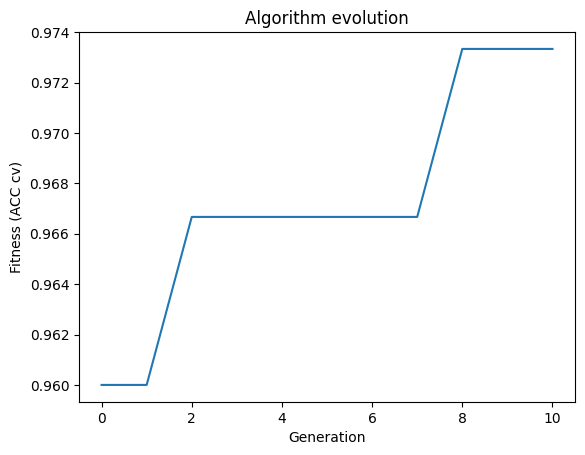

In [81]:
def VisualizaEvolucion(best_outputs):
    fig, ax = plt.subplots()
    ax.set_title("Algorithm evolution")
    plt.plot(best_outputs)
    plt.xlabel("Generation")
    plt.ylabel("Fitness (ACC cv)")
    plt.show()
    
VisualizaEvolucion(best_outputs)